# Jan 28th, 2022 (SE debug: cont.)

**Motivation**: Why such large standard error for animals but not for the group?  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def plot_df_se(df, title=None, bbox_to_anchor=(1.07, 0.55)):
    fg = sns.catplot(
        data=df,
        x='oc_idx',
        y='SE',
        hue='label',
        col='bin_idx',
        col_wrap=2,
        kind='point',
        height=3.5,
        ci=None,
    )
    for ax in fg.axes.flat:
        ax.grid(ls=':')
        ax.set_title(ax.get_title(), fontsize=13)
        ax.set_xlabel(ax.xaxis.get_label().get_text(), fontsize=13)
        ax.set_ylabel(ax.yaxis.get_label().get_text(), fontsize=13)

    plt.setp(fg.legend, bbox_to_anchor=bbox_to_anchor)
    for text in fg.legend.get_texts():
        plt.setp(text, fontsize=14)
    fg.legend.set_title(title)
    plt.setp(fg.legend.get_title(), fontsize=15)
    plt.show()
    
    return fg

## Prepare

In [3]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [4]:
props_base = {
    'num_k': 5,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'perc': 'p20-sample', **props_base}
props_bold = {'perc': 'p20-sample', **props_base}

gr_ca = Group(mode='ca2', centroids_from='runs', **props_ca).fit_group(skip_align=False)
gr_bold = Group(mode='bold-lite', centroids_from='runs', **props_bold).fit_group(skip_align=False)

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

## Membership plot

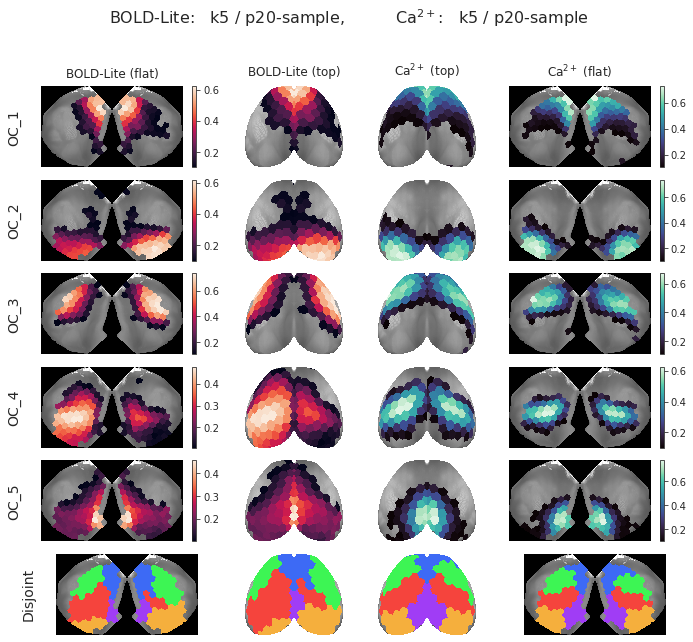

In [5]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

## Proportions (group)

In [6]:
# Load SciPy boot
boot_bca = 'boot-BCa_group_5.0e+03_(2022_01_27).npy'
boot_bca = np.load(pjoin(tmp_dir, boot_bca), allow_pickle=True)
boot_bca = boot_bca.item()

# Load full boot
boot_gam = {}
for mode in ['ca2', 'bold-lite']:
    b = f'boot-{mode}_group_5.0e+03_(2022_01_27).npy'
    boot_gam[mode] = np.load(pjoin(tmp_dir, b), mmap_mode='r')

# Prepare gam booted
_stat = mk_statistic_fn(gr_bold.bins, est_seed=None)

output_booted_ca = _stat(boot_gam['ca2'])
output_booted_bold = _stat(boot_gam['bold-lite'])

In [7]:
mu_real = gr_ca.grp_cut
mu_boot = output_booted_ca['cut_avg'].mean(0)
delta_mu_ca = (mu_real - mu_boot) / mu_real
delta_mu_ca *= 100

mu_real = gr_bold.grp_cut
mu_boot = output_booted_bold['cut_avg'].mean(0)
delta_mu_bold = (mu_real - mu_boot) / mu_real
delta_mu_bold *= 100

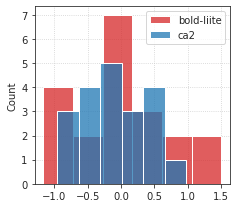

In [8]:
fig, ax = create_figure(figsize=(3.4, 3))
sns.histplot(delta_mu_bold.flat, color='C3', label='bold-liite', ax=ax)
sns.histplot(delta_mu_ca.flat, color='C0', label='ca2', ax=ax)
ax.legend()
ax.grid()
plt.show()

Fig: distribution of % difference between real mean and boostrapped mean.  We see that the mean of bootstrapped samples is very close to the actual means. Distribution is over communities and bins: $5 * 4 = 20$ numbers per modality.

In [9]:
df_se_ca = gr_ca.mk_se_df(
    se_bca=boot_bca['ca2']['se'],
    samples_boot=output_booted_ca['cut_avg'],
)
df_se_bold = gr_bold.mk_se_df(
    se_bca=boot_bca['bold-lite']['se'],
    samples_boot=output_booted_bold['cut_avg'],
)

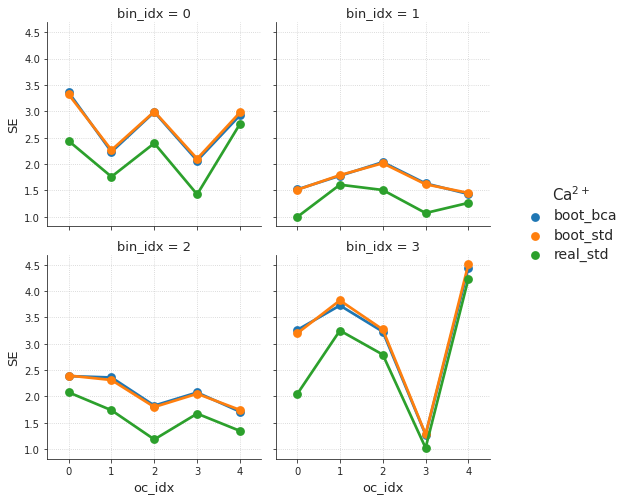

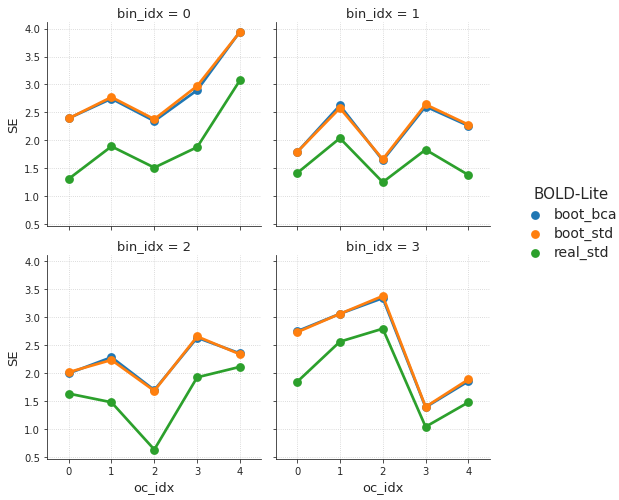

In [10]:
_ = plot_df_se(df_se_ca, r"Ca$^{2+}$")
_ = plot_df_se(df_se_bold, 'BOLD-Lite')

In [11]:
rng = get_rng()
a = rng.normal(0, 1, 50)

sp_stats.sem(a), a.std(ddof=1) / np.sqrt(len(a))

(0.10865080760057222, 0.10865080760057222)

In [12]:
ci = 0.95
n = 10
sp_stats.t.ppf((1 + ci) / 2., n-1), sp_stats.t.ppf((1 - ci) / 2., n-1)

(2.2621571627409915, -2.2621571627409915)

In [15]:
ci = 0.95
n = 3
sp_stats.t.ppf((1 + ci) / 2., n-1), sp_stats.t.ppf((1 - ci) / 2., n-1)

(4.302652729911275, -4.302652729911275)

In [16]:
ci = 0.95
n = 12
sp_stats.t.ppf((1 + ci) / 2., n-1), sp_stats.t.ppf((1 - ci) / 2., n-1)

(2.200985160082949, -2.200985160082949)

In [17]:
gr_ca.run_gam.shape

(10, 3, 4, 500, 5, 174)

In [18]:
shape_orig = gr_ca.run_gam.shape
x = gr_ca.run_gam.reshape((shape_orig[0], -1, *shape_orig[-3:]))
x.shape

(10, 12, 500, 5, 174)

In [19]:
gr_ca.run_gam.shape

(10, 3, 4, 500, 5, 174)

In [21]:
est_seed = bn.nanmean
dims = {'d0': 10, 'd1': 3, 'd2': 4, 'd3': 500}
b = bootstrap(
    x=gr_ca.run_gam,
    n_resamples=300,
    batch=5,
    dims=dims,
    indiv=True,
    est=est_seed,
)

In [22]:
b.shape

(300, 10, 3, 4, 5, 174)

In [38]:
pi.shape

(300, 10, 3, 4, 5, 174)

In [23]:
pi = pi_from_gam(b, -3, -2, est_seed=None)
k, n = pi.shape[-2:]
cut, _ = cut_data(
    data=pi.reshape(-1, k, n),
    bins=gr_ca.bins,
    oc_only=True,
)
cut = cut.reshape((*pi.shape[:-2], k, -1))
# cut = bn.nanmean(cut, 2)

cut.shape, b.shape

((300, 10, 3, 4, 5, 4), (300, 10, 3, 4, 5, 174))

<AxesSubplot:ylabel='Density'>

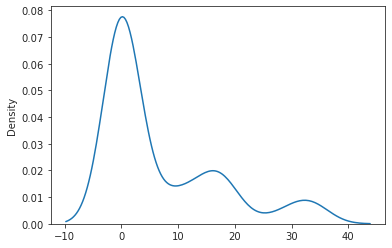

In [29]:
sns.kdeplot(cut[:, 3, 0, 0, 2, -1])

<AxesSubplot:ylabel='Density'>

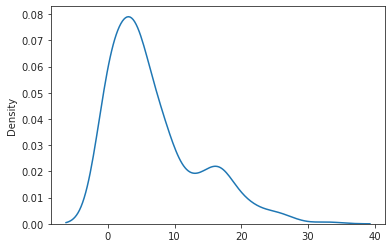

In [30]:
sns.kdeplot(bn.nanmean(cut, -3)[:, 3, 0, 2, -1])

<AxesSubplot:ylabel='Density'>

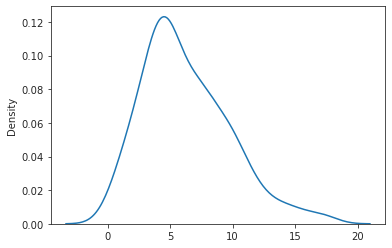

In [32]:
sns.kdeplot(bn.nanmean(bn.nanmean(cut, -3), -3)[:, 3, 2, -1])

In [36]:
np.nanstd(bn.nanmean(bn.nanmean(cut, -3), -3), 0, ddof=1)

array([[[ 6.13816191,  4.6487422 ,  4.07056495,  4.35281409],
        [ 4.2056527 ,  4.12794131,  4.8234421 ,  9.23737348],
        [ 4.33820264,  1.98437863,  2.24169753,  5.99220564],
        [ 4.41211949,  3.29056932,  4.47325834,  1.21894568],
        [ 5.59589691,  1.64550048,  3.67869894,  8.79797708]],

       [[ 8.49786449,  2.04460175,  5.5514452 , 11.50321086],
        [ 7.8007486 ,  3.70404238,  4.33737827,  7.20373752],
        [ 5.92538056,  2.37685618,  6.11881206,  6.4798799 ],
        [ 3.07170276,  3.24843961,  4.17499159,  2.49555737],
        [ 1.98676261,  2.55747687,  3.42980455,  2.58492112]],

       [[ 4.63803314,  4.99121447,  2.73932085,  5.00015506],
        [ 5.69359524,  3.6504578 ,  4.06947674,  5.69076278],
        [ 4.30414567,  1.9297778 ,  5.70652314,  5.21420529],
        [ 6.41613787,  3.56612809,  4.07040977,  0.6789785 ],
        [ 6.52366798,  3.89699702,  3.48492644,  9.56366935]],

       [[ 6.45771647,  3.46907593,  2.59801647,  7.570559  ],
        [ 4.40428239,  3.83055495,  3.12422244,  3.49706345],
        [ 6.20740645,  3.67975132,  4.12995498,  3.50662325],
        [ 8.95809886,  6.29545959,  4.66251025,  1.49752535],
        [ 5.25613922,  2.44627068,  4.40903525,  3.60249956]],

       [[ 2.74426444,  4.246324  ,  3.71165236,  6.48670039],
        [ 3.83384086,  3.053879  ,  3.3059365 ,  4.80863302],
        [ 5.27613601,  3.99675904,  5.41863247,  1.25707661],
        [ 2.53482365,  2.06652612,  4.15535699,  4.03919916],
        [ 3.85104405,  2.91907799,  3.2696208 ,  2.34753959]],

       [[ 5.76919004,  3.00890095,  4.93125932,  6.5153077 ],
        [ 3.72866528,  2.09063411,  1.72575304,  4.09825018],
        [ 5.55709532,  3.74105708,  3.05555373,  7.78638061],
        [ 3.06817357,  2.34239929,  3.10803035,  1.39000936],
        [ 3.8757785 ,  2.84784717,  3.44650717,  5.36783686]],

       [[11.36924678,  3.97376634,  3.23419231, 15.60370347],
        [ 2.55509872,  1.77920218,  6.50189282,  7.0587738 ],
        [ 6.6160225 ,  2.23197498,  3.10214528,  6.3805541 ],
        [ 4.44674592,  3.87273748,  4.7412411 ,  5.28269917],
        [ 4.82701777,  1.81487638,  5.63542997,  9.23650695]],

       [[11.82962678,  5.14507882,  3.70654516,  9.41030102],
        [ 5.70135499,  1.39678981,  7.80101687,  8.57869077],
        [ 5.41407582,  9.16703087,  5.72002717,  6.8151687 ],
        [ 6.34566085,  5.47952005,  4.70563775,  3.19125797],
        [ 4.60829025,  2.23317659,  2.63601526,  8.02316816]],

       [[ 6.23342046,  2.45382207,  4.60168003,  5.38861647],
        [ 4.47598195,  1.75673712,  8.83109386, 11.26888382],
        [ 5.04248984,  5.10199   ,  4.55609498,  6.63466258],
        [ 3.35964508,  5.01038855,  3.47188189,  3.25265057],
        [ 5.03753218,  2.94933501,  3.12370352,  7.4918544 ]],

       [[ 5.84231715,  3.37556503,  6.89107236,  7.34299783],
        [ 3.73535942,  3.26438747,  4.61544486,  5.41059274],
        [ 7.33944594,  3.19068132,  3.88396833,  5.03018536],
        [ 4.96655683,  2.03988939,  4.32239496,  0.52468816],
        [ 4.12605267,  2.79963508,  3.65733577,  4.70952484]]])

In [37]:
np.nanstd(bn.nanmean(bn.nanmean(bn.nanmean(cut, -3), -3), -3), 0, ddof=1)

array([[2.31284168, 1.2376097 , 1.38031446, 2.77298902],
       [1.594814  , 0.96390594, 1.71915613, 2.15158629],
       [1.76478282, 1.40008555, 1.46784315, 1.71293767],
       [1.66230823, 1.27347791, 1.32827372, 0.8805194 ],
       [1.49284567, 0.79612354, 1.23391312, 2.18973249]])

In [70]:
se_boot = np.nanstd(cut, axis=0, ddof=1)
se_boot.shape

(10, 5, 4)

In [71]:
anim = 3

In [72]:
se_boot[anim]

array([[5.21235007, 2.67524733, 2.34988306, 7.12903171],
       [4.16481462, 3.70898732, 3.20348288, 3.90777309],
       [5.38775118, 3.72411029, 3.90989716, 2.8438813 ],
       [6.68579292, 5.08891415, 3.54855134, 1.30922649],
       [4.27894139, 2.40200692, 4.13185121, 2.83312458]])

In [86]:
gr_ca.run_gam.shape

(10, 3, 4, 500, 5, 174)

In [99]:
sub = 3
ses = 1
run = 2
x = gr_ca.run_gam[sub, ses, run]
cut, _ = cut_data(
    data=x,
    bins=gr_ca.bins,
    oc_only=True,
)
cut.shape

(500, 5, 4)

<AxesSubplot:ylabel='Count'>

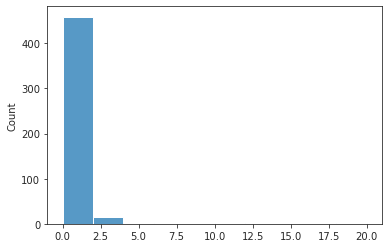

In [105]:
sns.histplot(cut[:, 4, -1])

In [ ]:
est_seed = bn.nanmean
dims = {'d0': 10, 'd1': 12, 'd2': 500}
b = bootstrap(
    x=x,
    n_resamples=200,
    batch=5,
    dims=dims,
    indiv=True,
    est=est_seed,
)

## Cut distribution

In [58]:
pi = pi_from_gam(gr_ca.run_gam)
gam = bn.nanmean(gr_ca.run_gam, -3)

In [60]:
pi.shape, gam.shape

((10, 3, 4, 5, 174), (10, 3, 4, 5, 174))

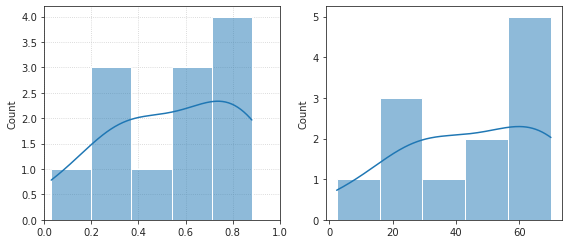

In [61]:
anim = 3
k = 0
n = 13

fig, axes = create_figure(1, 2, (8, 3.5))
sns.histplot(pi[anim, ..., k, n].flat, kde=True, ax=axes[0])
sns.histplot(gam[anim, ..., k, n].flat, kde=True, ax=axes[1])
axes[0].set_xlim(0, 1.0)
axes[0].grid()

In [65]:
pi[anim, 0, 0, :, n], gam[anim, 0, 0, :, n]

(
    array([0.02985429, 0.53458769, 0.4091257 , 0.02374992, 0.0026824 ]),
    array([ 2.37760757, 42.57477798, 32.58293501,  1.89145354,  0.21362748])
)

In [66]:
pi[anim, 0, 1, :, n], gam[anim, 0, 1, :, n]

(
    array([0.54437667, 0.1229219 , 0.28927498, 0.01887863, 0.02454783]),
    array([44.80895412, 10.11799739, 23.81091984,  1.55394539,  2.0205911 ])
)

In [67]:
proj_1 = gr_ca.project_vec(pi[anim, 0, 0])
proj_2 = gr_ca.project_vec(pi[anim, 0, 1])

In [71]:
gr_ca.run_gam.shape

(10, 3, 4, 500, 5, 174)

In [72]:
boot_gam['ca2'].shape

(5000, 10, 3, 4, 5, 174)

In [100]:
x = pi_from_gam(boot_gam['ca2'], est_seed=None)
y = bn.nanmean(bn.nanmean(bn.nanmean(x, 3) , 2), 1)
z = bn.nanmean(bn.nanmean(x, 3) , 2)

y.shape, z.shape

((5000, 5, 174), (5000, 10, 5, 174))

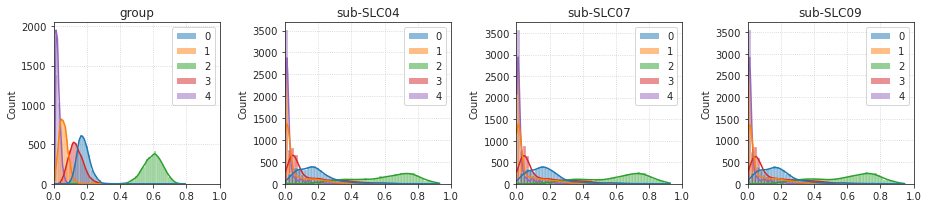

In [105]:
n = 21

fig, axes = create_figure(1, 4, (13, 3))
sns.histplot(y[:, :, n], kde=True, ax=axes[0])
axes[0].set_title('group')

for i, anim in enumerate([3, 6, 8], start=1):
    sns.histplot(z[:, anim, :, n], kde=True, ax=axes[i])
    axes[i].set_title(mice.get_key(anim + 1))

for ax in axes.flat:
    ax.set_xlim(0, 1.0)
    ax.grid()
    
plt.show()

In [106]:
# Load SciPy boot
boot_bca = 'boot-BCa_indiv_5.0e+03_(2022_01_27).npy'
boot_bca = np.load(pjoin(tmp_dir, boot_bca), allow_pickle=True)
boot_bca = boot_bca.item()

# Load full boot
boot_gam = {}
for mode in ['ca2', 'bold-lite']:
    b = f'boot-{mode}_indiv_5.0e+03_(2022_01_27).npy'
    boot_gam[mode] = np.load(pjoin(tmp_dir, b), mmap_mode='r')

# Prepare gam booted
_stat = mk_statistic_fn(gr_bold.bins, est_seed=None)

output_booted_ca = _stat(boot_gam['ca2'])
output_booted_bold = _stat(boot_gam['bold-lite'])

In [107]:
x = pi_from_gam(boot_gam['ca2'], est_seed=None)
y = bn.nanmean(bn.nanmean(bn.nanmean(x, 3) , 2), 1)
z = bn.nanmean(bn.nanmean(x, 3) , 2)

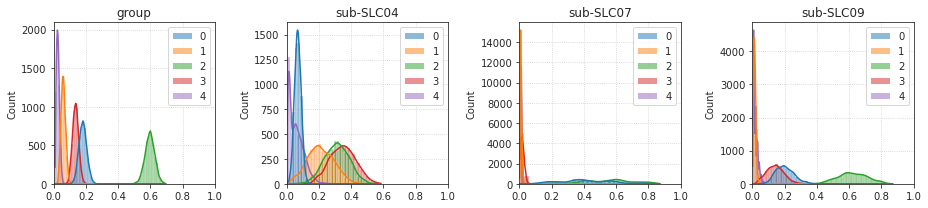

In [108]:
n = 21

fig, axes = create_figure(1, 4, (13, 3))
sns.histplot(y[:, :, n], kde=True, ax=axes[0])
axes[0].set_title('group')

for i, anim in enumerate([3, 6, 8], start=1):
    sns.histplot(z[:, anim, :, n], kde=True, ax=axes[i])
    axes[i].set_title(mice.get_key(anim + 1))

for ax in axes.flat:
    ax.set_xlim(0, 1.0)
    ax.grid()
    
plt.show()

<AxesSubplot:ylabel='Count'>

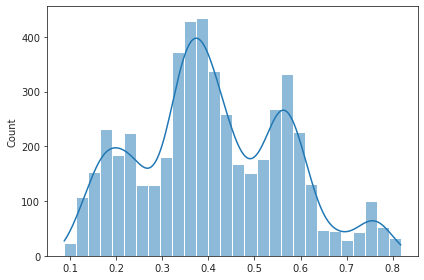

In [127]:
anim = 6

fig, ax = create_figure()
sns.histplot(z[:, anim, 0, n], kde=True, ax=ax, stat='count')

In [139]:
%%time

dims = {'d1': 3, 'd2': 4, 'd3': 500}

boot_correct = bootstrap(
    x=gr_ca.run_gam[anim],
    n_resamples=10000,
    batch=5,
    dims=dims,
    est=bn.nanmean,
)
boot_correct.shape

CPU times: user 3min 40s, sys: 1min 56s, total: 5min 37s
Wall time: 5min 37s


(10000, 3, 4, 5, 174)

In [140]:
x_correct = pi_from_gam(boot_correct, est_seed=None)
z_correct = bn.nanmean(bn.nanmean(x_correct, 2) , 1)
x_correct.shape, z_correct.shape

((10000, 3, 4, 5, 174), (10000, 5, 174))

<AxesSubplot:ylabel='Count'>

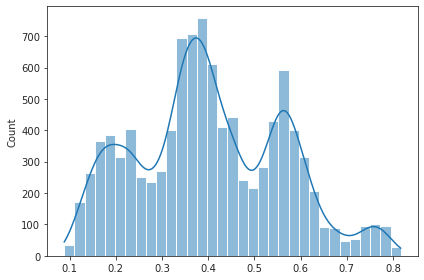

In [142]:
anim = 6

fig, ax = create_figure()
sns.histplot(z_correct[:, 0, n], kde=True, ax=ax, stat='count')

In [175]:
data = gr_ca.run_gam[anim, ..., :, n]
data.shape

(3, 4, 500, 5)

In [185]:
dims = {'d0': 3, 'd1': 4, 'd2': 500}
ids, shape = resample(dims, batch=10000, rng=get_rng())
ids = tuple(e for e in ids.values())
shape = (*shape, 5)

In [186]:
shape

(10000, 3, 4, 500, 5)

In [204]:
boot_super = data[ids].reshape(shape)
boot_super = pi_from_gam(boot_super, axis_seed=-2, axis_comm=-1, est_seed=bn.nanmean)
boot_super.shape

(10000, 3, 4, 5)

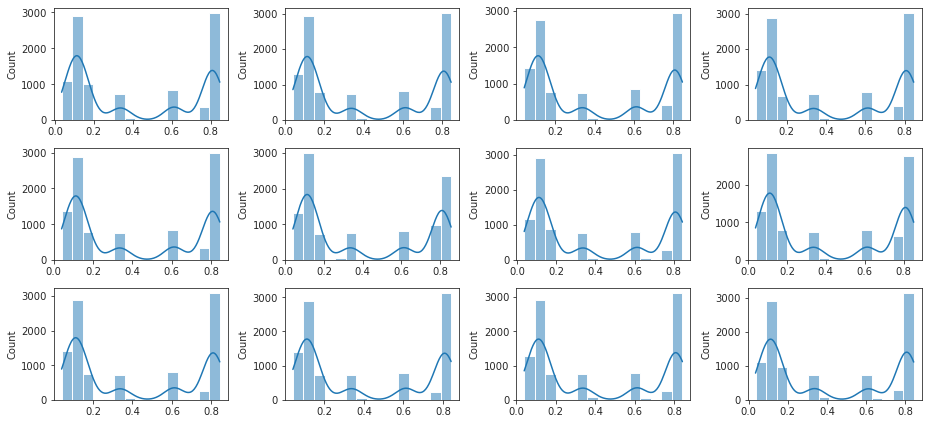

In [205]:
fig, axes = create_figure(3, 4, (13, 6))

for i in range(3):
    for j in range(4):
        ax = axes[i, j]
        sns.histplot(boot_super[:, i, j, 0], kde=True, ax=ax)

<AxesSubplot:ylabel='Count'>

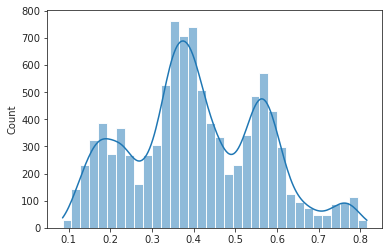

In [188]:
sns.histplot(bn.nanmean(bn.nanmean(boot_super[..., 0], -1), -1), kde=True)

In [193]:
shape[:-1]

(10000, 3, 4, 500)

In [194]:
ids[0].reshape(shape[:-1])

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2]],

        [[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]]],


       [[[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]],

        [[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]],

        [[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2]]],


       [[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],


       ...,


       [[[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]]],


       [[[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2]]],


       [[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2]],

        [[2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2],
         [2, 2, 2, ..., 2, 2, 2]]]])

In [195]:
b = 975
ses = 1
run = 2
seed = 123

In [198]:
[e.reshape(shape[:-1])[b, ses, run, seed] for e in ids]

[1, 2, 454]

In [202]:
boot_super = data[ids].reshape(shape)[b, ses, run, seed]
boot_super

array([37.6498827 ,  0.23754634, 45.96327992,  0.24069382,  0.23754634])

In [203]:
data[1, 2, 454]

memmap([37.6498827 ,  0.23754634, 45.96327992,  0.24069382,  0.23754634])

## Proportions (indiv)

In [12]:
# Load SciPy boot
boot_bca = 'boot-BCa_indiv_5.0e+03_(2022_01_27).npy'
boot_bca = np.load(pjoin(tmp_dir, boot_bca), allow_pickle=True)
boot_bca = boot_bca.item()

# Load full boot
boot_gam = {}
for mode in ['ca2', 'bold-lite']:
    b = f'boot-{mode}_indiv_5.0e+03_(2022_01_27).npy'
    boot_gam[mode] = np.load(pjoin(tmp_dir, b), mmap_mode='r')

# Prepare gam booted
_stat = mk_statistic_fn(gr_bold.bins, est_seed=None)

output_booted_ca = _stat(boot_gam['ca2'])
output_booted_bold = _stat(boot_gam['bold-lite'])

In [13]:
def fun(x, est_seed=None):
    pi = pi_from_gam(x, axis_comm=-2, axis_seed=-3, est_seed=est_seed)
    k, n = pi.shape[-2:]
    cut, _ = cut_data(
        data=pi.reshape(-1, k, n),
        bins=gr_ca.bins,
        oc_only=True,
    )
    cut = cut.reshape((*pi.shape[:-2], k, -1))
    return bn.nanmean(cut, -3)

### sub-SLC04 (anim = 3)

In [14]:
anim = 3

In [15]:
samples_real = fun(gr_ca.run_gam[anim], est_seed=bn.nanmean)
samples_boot = fun(boot_gam['ca2'][:, anim, ...], est_seed=None)
samples_boot = bn.nanmean(samples_boot, 1)

mu_real = bn.nanmean(samples_real, 0)
mu_boot = bn.nanmean(samples_boot, 0)
delta_mu_ca = (mu_real - mu_boot) / mu_real
delta_mu_ca *= 100

df_se_ca = gr_ca.mk_se_df(
    se_bca=boot_bca['ca2']['se'][anim],
    samples_boot=samples_boot,
    samples_real=samples_real,
)


samples_real = fun(gr_bold.run_gam[anim], est_seed=bn.nanmean)
samples_boot = fun(boot_gam['bold-lite'][:, anim, ...], est_seed=None)
samples_boot = bn.nanmean(samples_boot, 1)

mu_real = bn.nanmean(samples_real, 0)
mu_boot = bn.nanmean(samples_boot, 0)
delta_mu_bold = (mu_real - mu_boot) / mu_real
delta_mu_bold *= 100

df_se_bold = gr_bold.mk_se_df(
    se_bca=boot_bca['bold-lite']['se'][anim],
    samples_boot=samples_boot,
    samples_real=samples_real,
)

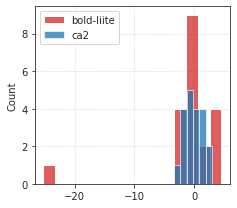

In [16]:
fig, ax = create_figure(figsize=(3.4, 3))
sns.histplot(delta_mu_bold.flat, color='C3', label='bold-liite', ax=ax)
sns.histplot(delta_mu_ca.flat, color='C0', label='ca2', ax=ax)
ax.legend()
ax.grid()
plt.show()

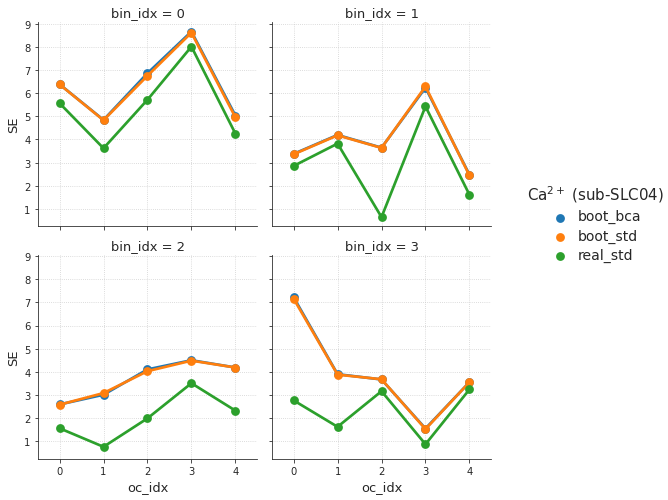

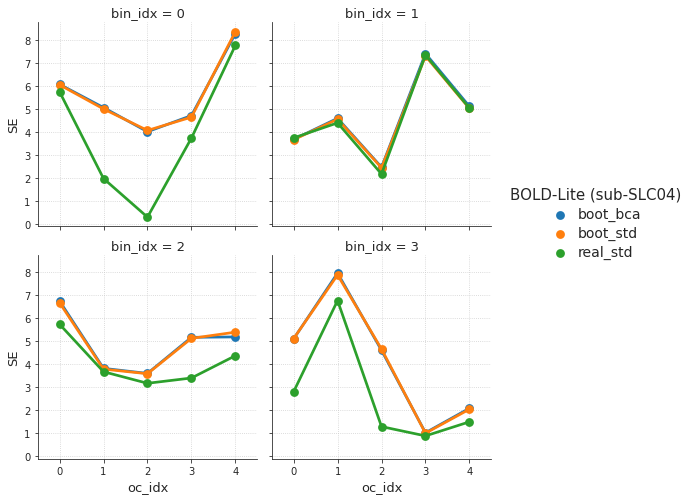

In [17]:
_ = plot_df_se(df_se_ca, r"Ca$^{2+}$" + f" (sub-SLC{anim + 1:02d})", (1.15, 0.55))
_ = plot_df_se(df_se_bold, 'BOLD-Lite' + f" (sub-SLC{anim + 1:02d})", (1.18, 0.55))

In [37]:
ids, shape = resample({'d0': 6, 'd1': 3}, batch=5)
shape

(5, 6, 3)

In [38]:
ids

{
    'd0': array([0, 0, 0, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 5, 5, 5, 0, 0, 0, 4,
       4, 4, 1, 1, 1, 0, 0, 0, 3, 3, 3, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 3, 3, 0, 0, 0, 5, 5, 5, 2, 2, 2, 3, 3, 3, 2, 2, 2,
       1, 1, 1, 5, 5, 5, 4, 4, 4, 3, 3, 3, 2, 2, 2, 4, 4, 4, 3, 3, 3, 2,
       2, 2]),
    'd1': array([1, 0, 0, 1, 2, 0, 2, 2, 0, 1, 0, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 0,
       1, 1, 1, 0, 1, 0, 2, 2, 2, 2, 1, 2, 1, 0, 2, 1, 0, 1, 2, 0, 1, 0,
       2, 1, 0, 0, 1, 2, 2, 1, 0, 2, 1, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 0,
       0, 2, 1, 0, 2, 0, 2, 0, 2, 2, 2, 1, 1, 2, 0, 2, 1, 1, 1, 1, 0, 0,
       0, 0])
}

In [39]:
ids['d0'].reshape(shape)

array([[[0, 0, 0],
        [4, 4, 4],
        [3, 3, 3],
        [2, 2, 2],
        [2, 2, 2],
        [5, 5, 5]],

       [[0, 0, 0],
        [4, 4, 4],
        [1, 1, 1],
        [0, 0, 0],
        [3, 3, 3],
        [5, 5, 5]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        [3, 3, 3],
        [0, 0, 0]],

       [[5, 5, 5],
        [2, 2, 2],
        [3, 3, 3],
        [2, 2, 2],
        [1, 1, 1],
        [5, 5, 5]],

       [[4, 4, 4],
        [3, 3, 3],
        [2, 2, 2],
        [4, 4, 4],
        [3, 3, 3],
        [2, 2, 2]]])

In [40]:
ids['d1'].reshape(shape)

array([[[1, 0, 0],
        [1, 2, 0],
        [2, 2, 0],
        [1, 0, 2],
        [2, 1, 0],
        [2, 1, 2]],

       [[2, 2, 2],
        [0, 1, 1],
        [1, 0, 1],
        [0, 2, 2],
        [2, 2, 1],
        [2, 1, 0]],

       [[2, 1, 0],
        [1, 2, 0],
        [1, 0, 2],
        [1, 0, 0],
        [1, 2, 2],
        [1, 0, 2]],

       [[1, 2, 0],
        [0, 2, 2],
        [1, 2, 2],
        [1, 2, 0],
        [0, 2, 1],
        [0, 2, 0]],

       [[2, 0, 2],
        [2, 2, 1],
        [1, 2, 0],
        [2, 1, 1],
        [1, 1, 0],
        [0, 0, 0]]])

In [41]:
ids, shape = resample({'d0': 6, 'd1': 3}, skip=['d0'], batch=5)
shape

(5, 6, 3)

In [43]:
ids['d1'].reshape(shape)

array([[[0, 2, 1],
        [1, 1, 2],
        [0, 2, 0],
        [0, 1, 2],
        [2, 2, 2],
        [2, 1, 0]],

       [[2, 1, 1],
        [1, 0, 2],
        [2, 1, 1],
        [2, 1, 1],
        [1, 0, 0],
        [1, 2, 0]],

       [[2, 2, 0],
        [1, 0, 2],
        [2, 1, 0],
        [2, 1, 2],
        [2, 2, 2],
        [0, 1, 1]],

       [[1, 0, 1],
        [0, 2, 2],
        [2, 2, 1],
        [2, 1, 0],
        [2, 1, 0],
        [1, 2, 0]],

       [[1, 0, 2],
        [1, 0, 0],
        [1, 2, 2],
        [1, 0, 2],
        [1, 2, 0],
        [0, 2, 2]]])

In [ ]:
x = fun(boot_gam['ca2'], est_seed=None)
x.shape

### All animals

In [ ]:
for anim in range(10):
    samples_real = fun(gr_ca.run_gam[anim], est_seed=bn.nanmean)
    samples_boot = fun(boot_gam['ca2'][:, anim, ...], est_seed=None)
    samples_boot = bn.nanmean(samples_boot, 1)

    mu_real = bn.nanmean(samples_real, 0)
    mu_boot = bn.nanmean(samples_boot, 0)
    delta_mu_ca = (mu_real - mu_boot) / mu_real
    delta_mu_ca *= 100

    df_se_ca = gr_ca.mk_se_df(
        se_bca=boot_bca['ca2']['se'][anim],
        samples_boot=samples_boot,
        samples_real=samples_real,
    )


    samples_real = fun(gr_bold.run_gam[anim], est_seed=bn.nanmean)
    samples_boot = fun(boot_gam['bold-lite'][:, anim, ...], est_seed=None)
    samples_boot = bn.nanmean(samples_boot, 1)

    mu_real = bn.nanmean(samples_real, 0)
    mu_boot = bn.nanmean(samples_boot, 0)
    delta_mu_bold = (mu_real - mu_boot) / mu_real
    delta_mu_bold *= 100

    df_se_bold = gr_bold.mk_se_df(
        se_bca=boot_bca['bold-lite']['se'][anim],
        samples_boot=samples_boot,
        samples_real=samples_real,
    )
    
    fig, ax = create_figure(figsize=(3.4, 3))
    sns.histplot(delta_mu_bold.flat, color='C3', ax=ax)
    sns.histplot(delta_mu_ca.flat, color='C0', ax=ax)
    ax.grid()
    plt.show()

    _ = plot_df_se(df_se_ca, r"Ca$^{2+}$" + f" (sub-SLC{anim + 1:02d})", (1.15, 0.55))
    _ = plot_df_se(df_se_bold, 'BOLD-Lite' + f" (sub-SLC{anim + 1:02d})", (1.18, 0.55))
    
    print('-' * 80)
    print('-' * 80)
    print('\n\n')

## Run boot temp

In [ ]:
%%time

n_resamples = 1000 * 5

boot_bca, boot_gam = boot_group(
    gam_dict={
        gr_ca.mode: gr_ca.run_gam,
        gr_bold.mode: gr_bold.run_gam},
    n_resamples=n_resamples,
    bins=gr_bold.bins,
    save_dir=tmp_dir,
    indiv=True,
)
boot_bca, boot_gam = boot_group(
    gam_dict={
        gr_ca.mode: gr_ca.run_gam,
        gr_bold.mode: gr_bold.run_gam},
    n_resamples=n_resamples,
    bins=gr_bold.bins,
    save_dir=tmp_dir,
    indiv=False,
)

[PROGRESS] 'boot-BCa_indiv_5.0e+03_(2022_01_27).npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

[PROGRESS] 'boot-ca2_indiv_5.0e+03_(2022_01_27).npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

[PROGRESS] 'boot-bold-lite_indiv_5.0e+03_(2022_01_27).npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp